In [60]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from Bio import Align
from scipy import spatial
import scipy.stats
import tqdm

from pymutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    translator, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from pymutspec.io import read_genbank_ref
from pymutspec.draw import plot_mutspec12, plot_mutspec192, plot_mutspec192kk
from pymutspec.draw.sbs_orders import ordered_sbs192_kp as ordered_sbs192

sns.set_style("whitegrid")
coda = CodonAnnotation(2)

In [39]:
gtex = pd.read_csv("../data/external/GTExRef.txt", )
gtex["Mut"] = gtex.Substitution.str.replace("_", ">")
print(gtex.shape)
gtex.head()

(2565, 15)


,Position,Mutation,SRR,AF,tissue,subject,nDonorTissue,BQ,COV,OTHERS_DONOR_AF,OTHERS_DONOR_COV,DerivedAllele,AncestralAllele,Substitution,Mut
0,1554,1554_A,SRR1500555,0.1021,Artery - Tibial,GTEX-1117F,13,35.7,186,0.0012,1241.3,A,G,G_A,G>A
1,16215,16215_A,SRR1413373,0.0525,Ovary,GTEX-1117F,13,37.9,362,0.0000,1421.8,A,G,G_A,G>A
2,4006,4006_G,SRR1413373,0.0930,Ovary,GTEX-1117F,13,37.5,3418,0.0001,31757.6,G,A,A_G,A>G
3,458,458_T,SRR1413373,0.0340,Ovary,GTEX-1117F,13,35.1,206,0.0000,614.0,T,C,C_T,C>T
4,67,67_A,SRR1309070,0.0604,Muscle - Skeletal,GTEX-1117F,13,35.5,745,0.0003,590.0,A,G,G_A,G>A


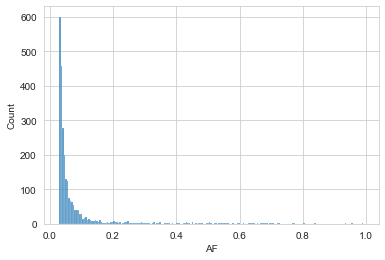

In [11]:
sns.histplot(gtex.AF);

In [55]:
refseq_hg19 = next(SeqIO.parse("../data/external/hg19_mt.gb", "gb"))
refseq_hg19_df = pd.read_csv("../data/external/hg19_chrM_refAllele.txt", comment="#", sep="\t", index_col=0)

In [78]:
a = "".join(refseq_hg19_df.Nuc.values)
b = refseq_hg19.seq

print(a)
print(b)
print(len(a), len(b))

GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCATGCATTTGGTATTTTCGTCTGGGGGGTGTGCACGCGATAGCATTGCGAGACGCTGGAGCCGGAGCACCCTATGTCGCAGTATCTGTCTTTGATTCCTGCCTCATTCTATTATTTATCGCACCTACGTTCAATATTACAGGCGAACATACCTACTAAAGTGTGTTAATTAATTAATGCTTGTAGGACATAATAATAACAATTGAATGTCTGCACAGCCGCTTTCCACACAGACATCATAACAAAAAATTTCCACCAAACCCCCCCCTCCCCCCGCTTCTGGCCACAGCACTTAAACACATCTCTGCCAAACCCCAAAAACAAAGAACCCTAACACCAGCCTAACCAGATTTCAAATTTTATCTTTAGGCGGTATGCACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCCTACCCAGCACACACACACCGCTGCTAACCCCATACCCCGAACCAACCAAACCCCAAAGACACCCCCCACAGTTTATGTAGCTTACCTCCTCAAAGCAATACACTGAAAATGTTTAGACGGGCTCACATCACCCCATAAACAAATAGGTTTGGTCCTAGCCTTTCTATTAGCTCTTAGTAAGATTACACATGCAAGCATCCCCGTTCCAGTGAGTTCACCCTCTAAATCACCACGATCAAAAGGGACAAGCATCAAGCACGCAGCAATGCAGCTCAAAACGCTTAGCCTAGCCACACCCCCACGGGAAACAGCAGTGATTAACCTTTAGCAATAAACGAAAGTTTAACTAAGCTATACTAACCCCAGGGTTGGTCAATTTCGTGCCAGCCACCGCGGTCACACGATTAACCCAAGTCAATAGAAGCCGGCGTAAAGAGTGTTTTAGATCACCCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAA

In [41]:
gtex["my_anc"] = gtex.Position.map({i:x for i, x in enumerate(refseq_hg19.seq, 1)})

In [54]:
(gtex.AncestralAllele == gtex.Position.map(refseq_hg19_df.Nuc.to_dict())).all()

True